# Estimation of Heterogeneous Treatment Effects

In [1]:
__author__ = "Jiting Jiang"
__email__ = "jiting.jiang@outlook.com"
__website__ = "https://jitingjiang.github.io/minimal-portfolio/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
from econml.dml import CausalForestDML as CausalForest

## Part I - Introduction

### Project Overview

In this project, I am going to estimate the Heterogeneous Treatment Effects (HTEs) of a large-scale randomized experiment in primary school students' academic learning (measured as standardized test scores), using Random Causal Forest (RCF) methods. The treatment provides a carefully chosen in-class library, a resource-type nudge intended to promote students' independent reading. 

I will build and interpret Random Causal Forest, a popular Machine Learning (ML) algorithm for Causal Inference (CI). I show below the codes I use to build random forests, predict the full distribution of individual TEs (as well as average treatment effects), and identify important correlates.

It is primarily Python-based and uses the EconML libraries developed by the ALICE team at Microsoft Research.

### Problem Background

Previous studies have shown null average treatment effects on academic learning of this type of interventions. I am interested in understanding if specific student subgroups benefit more (or less) from the treatment. The question is important to learn since it can provide insights on improving treatment targeting and treatment design.

To examine the heterogeneous treatment effects, a traditional way that economists use is to run regressions with interaction terms or separately estimate the treatment effects for subgroups. This approach comes with two main challenges. One is that the traditional heterogeneous analysis imposes functional form restrictions; another is related to the curse of dimensionality, where OLS can be infeasible if we have many covariates to consider.

Machine learning methods, however, may be an attractive alternative, given its flexibility and predictive accuracy. It can also help in selecting the important features. Here, I showcase the application of random causal forests (Wager and Athey, 2018), a data-driven approach, to investigate the role of students' characteristics in determining program effects.

### Dataset Information

The dataset used in the analysis below has been prepared from raw data collected by a research team at Stanford. It is presented in a .xlsx file, with each row representing a student and each column containing various features related to the student in years 2015, 2016 and 2017. These features include students' baseline characteristics, treatment status, and test scores for multiple years. I will specifically examine the treatment effects over a two-year period, using 2015 as the baseline year and 2017 as the endline year.

## Part II - Statistical Analysis

### 1. Import in data

The dataset has 5231 student records and 79 features. I later group the features into three groups: 

    y - the outcomes (i.e., endline subject test scores)
    z - the treatment (i.e, whether provided in-class library)
    x - the covariates (mostly student characteristics such as age, gender, and baseline subject test scores)

In [4]:
read2 = pd.read_csv('/Users/jitingjiang/OneDrive/Career/Courses/projects/project_readii_rcf/jiangxi_2015_2016_2017_g4_reshape.csv')
read2

,stu_code,sch_code2015,stu_female2015,stu_byear2015,stu_f_board2015,stu_sl_never2015,stu_cl_yes2015,stu_cl_never2015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,...,std_chi2017,treat2017,insurvey2017,hh_p_edu_high2017,hh_p_work_prof2017,hh_lb2017,hh_nofridge2017,stu_schrres2017,stu_SLR_std2017,stu_SCR_std2017
0,10114101,1011,1,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,0.0,0.0,NaN,0.0,-0.021379,-1.163930
1,10114102,1011,1,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,1.0,0.0,NaN,0.0,0.883299,0.378313
2,10114103,1011,1,2005.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,0.280180,-0.547033
3,10114104,1011,1,2004.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,1.184858,0.378313
4,10114105,1011,0,2004.0,0.0,1.0,0.0,1.0,1.0,0.0,...,NaN,0,1,0.0,0.0,1.0,NaN,0.0,0.280180,-0.238584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,31934124,3193,0,2005.0,0.0,1.0,1.0,0.0,1.0,0.0,...,-0.016498,0,1,0.0,0.0,0.0,NaN,1.0,1.486417,2.229004
5227,31934125,3193,1,2004.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,0,1,0.0,0.0,1.0,NaN,1.0,-0.322938,-0.855481
5228,31934126,3193,1,2005.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,0,1,0.0,0.0,0.0,NaN,1.0,-0.322938,0.069864
5229,31934127,3193,0,2005.0,0.0,1.0,1.0,1.0,0.0,0.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# define the variables
# the y
y1 = read2['std_read2017'] 
y2 = read2['std_chi2017']
y3 = read2['std_math2017']

# the z
z = read2['treat2015'] # treat assignment

# the x
x0 = read2[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015' #  Student reading habits (cont.)
           ]] 
x1 = read2['std_read2015']
x2 = read2['std_chi2015']
x3 = read2['std_math2015']

### 2. Clean the data

I then generate three separate samples, each containing unique subject test scores. The collected subject tests include reading, math, and language. Every students in the sample is expected to take the reading test while they either take math tests or chinese language tests (but not both) in survey waves. 

Next, I remove rows with missing values in the three datasets. After addressing the missing values, the reading, math, and language datasets consist of 3996, 1989, and 1988 observations, respectively.

#### 2.1 The Reading Dataset (df_read)

In [6]:
df_read = pd.concat([y1, z, x0, x1], axis=1)
df_read

,std_read2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_read2015
0,0.032943,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.666053
1,-0.755843,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.126665
2,0.821730,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
3,1.347588,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
4,-0.098521,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.736356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.690266,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.520601
5227,-1.807559,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.744829
5228,-1.018772,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-1.313318
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.097563


In [7]:
df_read = df_read.dropna()
df_read

,std_read2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_read2015
0,0.032943,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.666053
1,-0.755843,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.126665
2,0.821730,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
3,1.347588,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.736356
4,-0.098521,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.736356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224,-1.413166,0,2005.0,0,0.0,0.0,1.0,0.0,0.0,1,...,-1.389269,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.636951
5225,1.216123,0,2005.0,1,0.0,0.0,1.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.059989
5226,0.690266,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.520601
5227,-1.807559,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.744829


#### 2.2 The Math Dataset (df_math)

In [8]:
df_math = pd.concat([y3, z, x0, x3], axis=1)
df_math

,std_math2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_math2015
0,-1.406489,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.461401
1,-1.020534,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.587293
2,0.330309,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.415086
3,0.137331,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.790383
4,1.295197,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.227437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,NaN,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN
5227,-1.406489,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.774942
5228,-0.827557,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-0.649049
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.962590


In [9]:
df_math = df_math.dropna()
df_math

,std_math2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_math2015
0,-1.406489,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.461401
1,-1.020534,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,-1.587293
2,0.330309,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.415086
3,0.137331,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.790383
4,1.295197,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.227437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5217,-0.634579,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.836698
5219,-0.248624,0,2004.0,1,0.0,0.0,0.0,0.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-0.836698
5221,0.909242,0,2005.0,0,0.0,0.0,0.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.476843
5227,-1.406489,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.774942


#### 2.3 The Chinese Language Dataset (df_chi)

In [10]:
df_chi = pd.concat([y2, z, x0, x2], axis=1)
df_chi

,std_chi2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_chi2015
0,NaN,0,2004.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-1.389269,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
1,NaN,0,2004.0,1,0.0,0.0,1.0,0.0,0.0,0,...,-0.480438,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
2,NaN,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,0,...,-0.783381,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
3,NaN,0,2004.0,1,0.0,0.0,1.0,1.0,0.0,0,...,0.731337,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
4,NaN,0,2004.0,0,0.0,0.0,0.0,1.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,-0.016498,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.767136
5227,NaN,0,2004.0,1,0.0,0.0,0.0,0.0,1.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,NaN
5228,NaN,0,2005.0,1,0.0,0.0,0.0,1.0,0.0,1,...,0.428394,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
5229,NaN,0,2005.0,0,0.0,0.0,0.0,0.0,1.0,1,...,0.731337,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN


In [11]:
df_chi = df_chi.dropna()
df_chi

,std_chi2017,treat2015,stu_byear2015,stu_female2015,stu_f_board2015,hh_p_edu_high2015,hh_p_work_prof2015,hh_lb2015,hh_nofridge2015,stu_schrres2015,...,stu_SCR_std2015,stu_edu_r4chi2015,stu_edu_r4math2015,stu_sl_never2015,stu_cl_never2015,stu_home_rtime_a302015,stu_rfrd_rdiscuss2015,stu_rfrd_rtogether2015,stu_rfrd_rborrow2015,std_chi2015
6,-0.458121,0,2003.0,0,0.0,0.0,0.0,1.0,1.0,0,...,1.034281,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.714242
7,-0.458121,0,2005.0,0,0.0,0.0,0.0,1.0,0.0,0,...,0.428394,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.129301
8,-0.752537,0,2004.0,0,0.0,0.0,0.0,0.0,1.0,0,...,-1.692212,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.572629
9,-0.016498,0,2004.0,0,0.0,0.0,1.0,0.0,0.0,0,...,-1.086325,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.363277
15,0.866749,0,2004.0,1,0.0,0.0,0.0,0.0,0.0,0,...,-0.177494,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.533159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222,-0.163706,0,2004.0,0,0.0,0.0,0.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.104676
5223,-0.016498,0,2005.0,1,0.0,0.0,1.0,1.0,0.0,1,...,0.731337,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.455641
5224,-2.666240,0,2005.0,0,0.0,0.0,1.0,0.0,0.0,1,...,-1.389269,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.859500
5225,1.455581,0,2005.0,1,0.0,0.0,1.0,0.0,0.0,1,...,-0.480438,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.235089


### 3. Apply Random Causal Forest for HTE

Now it is ready to apply the Random Causal Forest method to assess the heterogeneous treatment effects. Here is a step-by-step description.

**First**, there are two identification assumptions for RCF to work. 

    Assumption 1: Conditional independence (or selection on observables)
    Assumption 2: Overlap
    
I argue the two assumptions hold in my case. For assumption 1, the "gold standard", namely randomized controlled trial, ensures the treatment is random and not correlated with students' characteristics. For assumption 2, the covariates I consider are quite general, such as gender, age, baseline test scores, with high probability of appearing in both treated and control groups.

**Second**, for each of the three datasets with unique subject test socres, I set the parameters of the causal forest and fit the model using CausalForestDML package from the double machine learning (dml) module of EconML.

Specifically, the splitting criterion is set to "het" for heterogeneous treatment effect, the number of trees is set to 500. The honest approach is also enabled by default. Random seed is set to 42 for replication purposes.

**Third**, after fitting the model, I first use it to (1) predict the individual Conditional Average Treatment Effects (CATEs) along with their corresponding confidence intervals. These predictions allow me to (2) visualize the distribution of the effects and confidence intervals (CI). Additionally, I (3) calculate the feature importance scores to identify the most influential feature for prediction. I further (4) analyze the relationship between the effects and the most important feature for each of the three datasets.

#### 3.1 For Reading Test Scores

#### 3.1.0 Fit the RCF Model

In [12]:
# define the variables
y = df_read['std_read2017'] 

z = df_read['treat2015'] # treat assignment

x = df_read[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_read2015']] 

In [13]:
# Instantiate the Causal Forest
rcf_read = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_read.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

#### 3.1.1 Predict Individual CATEs (along with CI)

In [14]:
# Calculate the predicted effects (for each observation)
insamplefx_read = rcf_read.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_read, ub_read = rcf_read.effect_interval(x, alpha=0.05)

In [15]:
# Merge CATEs into the original dataframe
df_read['effects'] = insamplefx_read
df_read['effects_lb'] = lb_read
df_read['effects_ub'] = ub_read


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_read[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.386544,-0.519302,-0.253786
1,-0.376608,-0.636609,-0.116607
2,-0.364840,-0.510812,-0.218869
3,-0.362338,-0.511530,-0.213145
4,-0.359729,-0.556248,-0.163211
...,...,...,...
3991,0.213253,-0.040131,0.466636
3992,0.217406,-0.075500,0.510311
3993,0.218265,-0.089683,0.526213
3994,0.225615,-0.025617,0.476846


#### 3.1.2 Visualize the Distribution of Predicted CATEs

I present two visualizations below. The first figure focuses on the spread of effect estimates with average effects (and its CI) overlaid. The second figure displays the confidence intervals for all the effect estimates arranged from the smallest to the largest.

Based on these plots, we can draw several interpretations: 
   * The average treatent effect is close to zero.
   * The estimated treatment effects vary from below -0.4 to above 0.2. 
   * Most of the treatment effects are not statistically different from zero.

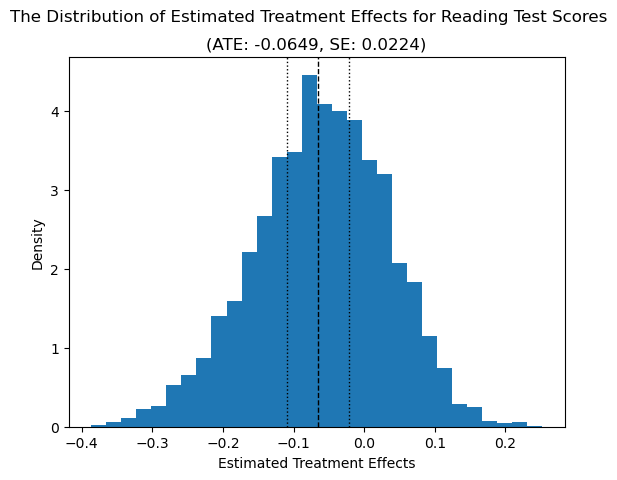

In [17]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_read, bins=30, density=True)
plt.axvline(rcf_read.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_read.ate_+1.96*rcf_read.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_read.ate_-1.96*rcf_read.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Reading Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_read.ate_[0], rcf_read.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

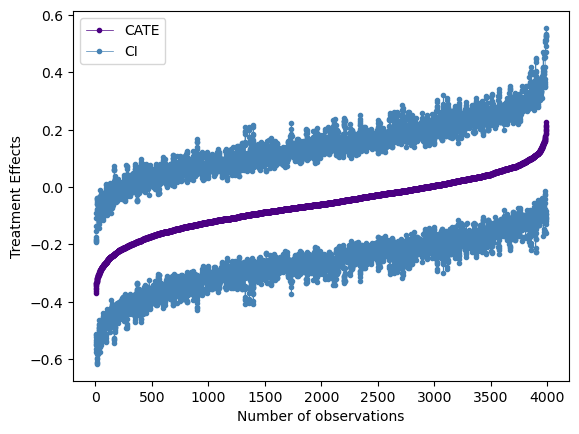

In [18]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

#### 3.1.3 Calculate Feature Importance

I then move onto calculate the feature importance, which indicates how often a variable is used in a tree split and reflects its contribution to the prediction. The table below presents the results, listing the features in descending order of importance. 

According to the feature importance rankings, the baseline standardized reading test scores had the highest importance (0.209), followed by the baseline standardized student like reading scores (0.146). 

In [19]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_read2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_read.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
std_read2015,0.209364
stu_SLR_std2015,0.145953
stu_SCR_std2015,0.129354
stu_byear2015,0.064212
stu_schrres2015,0.059820
stu_cl_yes2015,0.053486
stu_cl_never2015,0.047008
stu_female2015,0.035955
hh_lb2015,0.034201
stu_rfrd_rborrow2015,0.031844


#### 3.1.4 Visualize The Relationship Between Predicted CATEs and the Most Important Feature 

Now we know the feature importance, but it remains unclear how the most important feature relates to the predicted CATEs. One approach to gaining insight is by creating a scatter plot that displays indivisual values. The x-axis shows different values of the most important feature, while the y-axis represents the predicted effects. Additionally, smooth, local polynomial functions are fitted to the data to faciliate the interpretation. 

The plot below indicates a nonlinear and potential positive relationship between the baseline student reading test performance and the predicted treatment effects. Students who have a better reading test performance may be more likely to benefit from the treatment. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

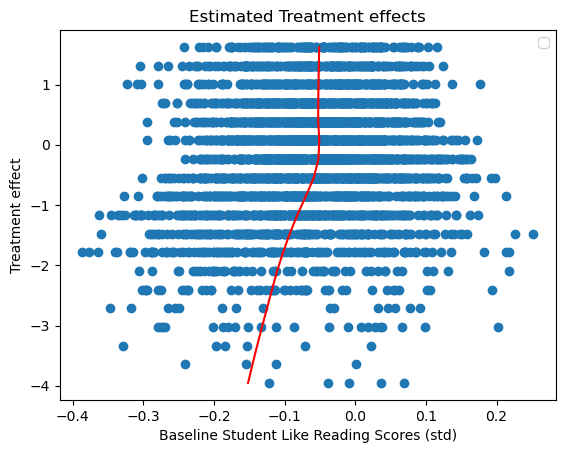

In [20]:
lowess = sm.nonparametric.lowess(df_read['effects'], df_read['stu_SLR_std2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_read['effects'], df_read['stu_SLR_std2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Student Like Reading Scores (std)")
plt.ylabel("Treatment effect")

#### 3.1.5 Assess Heterogeneity using Regressions

In addition to the scatter plot, I further assess the heterogeneity of treatment effects in subgroups by examining subgroups based on whether students score high in baseline reading test. To do this, I use regression models with interaction terms. Specifically, I define high-performing students in the baseline reading comprehension test as those with a baseline standardized reading score greater than or equal to 0, while those low-performing peers have a score less than 0. The interaction term is then the product of the treatment indicator and the baseline reading test performance dummy variable. The estimate of interest is the one before the interaction term. I keep all other covariates in the model as well. 

According to the OLS Regression Results, the coefficient before the interaction term is positive and statistically significant at a 5% confidence level, confirming the finding that students who have better reading performance at baseline may be more likely to benefit from the treatment. By summing up the estimates before the treatment indicator and the interaction term, low-performing studensts in the baseline reading test seems to be neither better off nor worse off from the intervention.

In [21]:
df_read['stu_highr'] = (df_read['std_read2015'] >= 0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
features_short = x[x.columns.drop(['std_read2015'])]

In [23]:
int_formula = 'std_read2017 ~ treat2015 + stu_highr + features_short + treat2015*stu_highr'
model = smf.ols(int_formula, data=df_read)
results = model.fit(cov_type="HC3")

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           std_read2017   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     110.0
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:54:09   Log-Likelihood:                -4550.2
No. Observations:                3996   AIC:                             9148.
Df Residuals:                    3972   BIC:                             9299.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Next, I repeated the analysis using the math dataset (df_math) and language dataset (df_chi). The key findings from both the math dataset and the language dataset are quite similar. Specifically, the average treatment effects are both found to be close to zero. However, the standard errors are larger compared to the reading datasets, which can be attributed to the reduced sample size. The most important feature in predicting the effects is baseline standardized math or language test scores, though no interesting heterogeneous patterns were observed in relation to this feature.

#### 3.2 For Math Test Scores

In [24]:
# define the variables
y = df_math['std_math2017'] 

z = df_math['treat2015'] # treat assignment

x = df_math[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
         'std_math2015']] 

In [25]:
# Instantiate the Causal Forest
rcf_math = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_math.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

In [26]:
# Calculate the predicted effects (for each observation)
insamplefx_math = rcf_math.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_math, ub_math = rcf_math.effect_interval(x, alpha=0.05)

In [27]:
# Merge CATEs into the original dataframe
df_math['effects'] = insamplefx_math
df_math['effects_lb'] = lb_math
df_math['effects_ub'] = ub_math


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_math[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.313846,-0.662024,0.034331
1,-0.264098,-0.664198,0.136002
2,-0.253374,-0.485489,-0.021260
3,-0.253281,-0.500915,-0.005647
4,-0.250964,-0.466851,-0.035076
...,...,...,...
1984,0.363872,0.034712,0.693031
1985,0.380152,0.213865,0.546440
1986,0.391084,-0.027672,0.809839
1987,0.400527,0.221590,0.579463


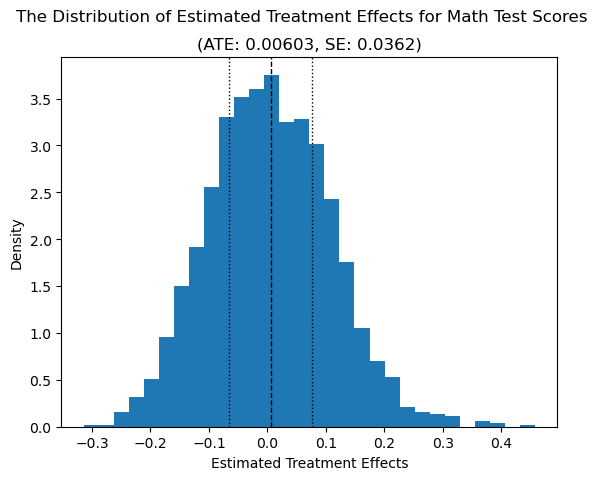

In [29]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_math, bins=30, density=True)
plt.axvline(rcf_math.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_math.ate_+1.96*rcf_math.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_math.ate_-1.96*rcf_math.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Math Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_math.ate_[0], rcf_math.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

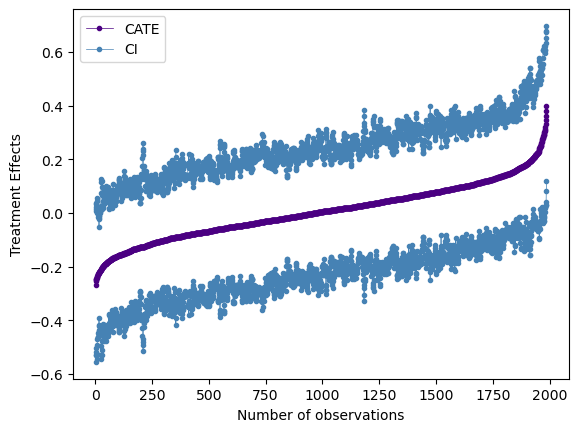

In [30]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

In [31]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_math2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_math.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
std_math2015,0.214237
stu_SLR_std2015,0.166545
stu_SCR_std2015,0.158331
stu_byear2015,0.064876
stu_female2015,0.046140
stu_rfrd_rborrow2015,0.044067
hh_lb2015,0.033090
stu_home_rtime_a302015,0.028989
stu_rfrd_rdiscuss2015,0.028979
stu_rfrd_rtogether2015,0.028475


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

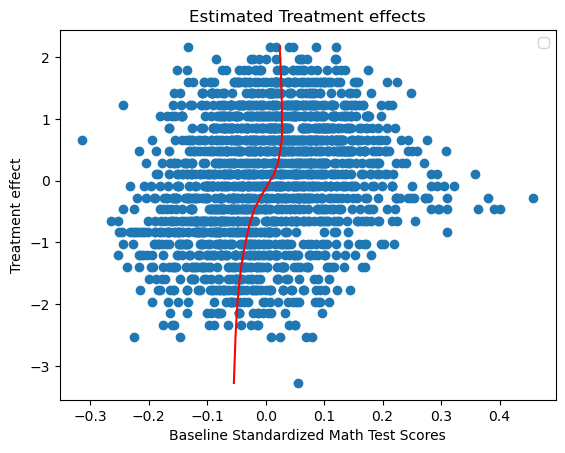

In [32]:
lowess = sm.nonparametric.lowess(df_math['effects'], df_math['std_math2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_math['effects'], df_math['std_math2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Standardized Math Test Scores")
plt.ylabel("Treatment effect")

In [33]:
df_math['stu_highm'] = (df_math['std_math2015'] >= 0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
features_short = x[x.columns.drop(['std_math2015'])]

In [35]:
int_formula = 'std_math2017 ~ treat2015 + stu_highm + features_short + treat2015*stu_highm'
model = smf.ols(int_formula, data=df_math)
results = model.fit(cov_type="HC3")

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           std_math2017   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     45.12
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          4.11e-162
Time:                        15:54:12   Log-Likelihood:                -2396.2
No. Observations:                1989   AIC:                             4840.
Df Residuals:                    1965   BIC:                             4975.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### 3.3 For Language Test Scores

In [36]:
# define the variables
y = df_chi['std_chi2017'] 

z = df_chi['treat2015'] # treat assignment

x = df_chi[['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_chi2015']] 

In [37]:
# Instantiate the Causal Forest
rcf_chi = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het", random_state=42)

# Grow the forest
rcf_chi.fit(
    y, z, X=x  # outcome  # treatment # prediction features
)  

In [38]:
# Calculate the predicted effects (for each observation)
insamplefx_chi = rcf_chi.effect(x)

# Calculate lower bound and upper bound confidence intervals (for each individual effect)
lb_chi, ub_chi = rcf_chi.effect_interval(x, alpha=0.05)

In [39]:
# Merge CATEs into the original dataframe
df_chi['effects'] = insamplefx_chi
df_chi['effects_lb'] = lb_chi
df_chi['effects_ub'] = ub_chi


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
# Create a new dataframe only storing effects along with confidence intervals 
effects_df = df_chi[['effects','effects_lb','effects_ub']]
                     
effects_df.sort_values('effects', inplace=True, ascending=True)                    
effects_df.reset_index(inplace=True, drop=True)
                     
# calculate rolling mean
smooth = effects_df.rolling(window=5, center=True).mean()

effects_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,effects,effects_lb,effects_ub
0,-0.345687,-0.687681,-0.003692
1,-0.336902,-0.673824,0.000020
2,-0.325574,-0.580106,-0.071042
3,-0.320674,-0.486919,-0.154428
4,-0.310459,-0.494588,-0.126330
...,...,...,...
1983,0.271459,-0.054305,0.597223
1984,0.271556,-0.055006,0.598118
1985,0.276039,-0.035613,0.587690
1986,0.307833,0.083840,0.531826


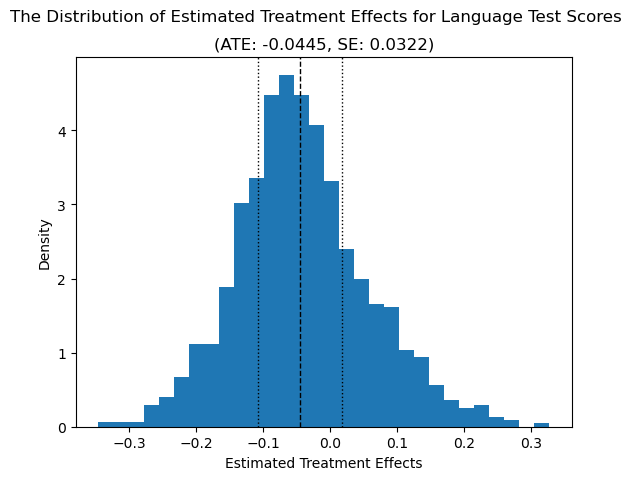

In [41]:
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()

ax.hist(insamplefx_chi, bins=30, density=True)
plt.axvline(rcf_chi.ate_, color="k", linestyle="dashed", linewidth=1)
plt.axvline(rcf_chi.ate_+1.96*rcf_chi.ate_stderr_, color="k", linestyle="dotted", linewidth=1)
plt.axvline(rcf_chi.ate_-1.96*rcf_chi.ate_stderr_, color="k", linestyle="dotted", linewidth=1)

plt.suptitle("The Distribution of Estimated Treatment Effects for Language Test Scores")
plt.title("(ATE: {:.3g}, SE: {:.3g})".format(rcf_chi.ate_[0], rcf_chi.ate_stderr_[0]))
ax.set_ylabel('Density')
ax.set_xlabel('Estimated Treatment Effects')
plt.show()

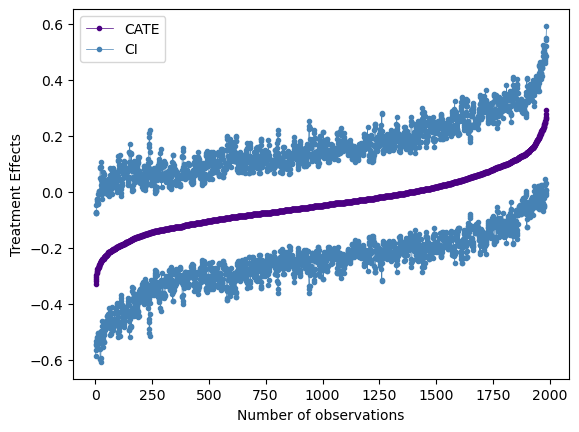

In [42]:
# Plot of the CATE and confidence intervals from the causal forest model
# set plot size
fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(smooth['effects'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(smooth['effects_lb'],
        marker='.', linestyle='-', linewidth=0.5, label='CI', color='steelblue')
ax.plot(smooth['effects_ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

In [43]:
features = ['stu_byear2015','stu_female2015','stu_f_board2015', # Individual student characteristics
        'hh_p_edu_high2015','hh_p_work_prof2015','hh_lb2015','hh_nofridge2015', # Family characteristics
        'stu_schrres2015','stu_cl_yes2015','stu_home_rbks_many2015', #  Reading resources
        'stu_SLR_std2015','stu_SCR_std2015','stu_edu_r4chi2015','stu_edu_r4math2015', #  Student attitudes toward reading
        'stu_sl_never2015','stu_cl_never2015','stu_home_rtime_a302015', #  Student reading habits
        'stu_rfrd_rdiscuss2015','stu_rfrd_rtogether2015','stu_rfrd_rborrow2015', #  Student reading habits (cont.)
        'std_chi2015']

feature_importance_df = pd.DataFrame({'Importance': rcf_chi.feature_importances_}, index=features)
feature_importance_df.sort_values(by=['Importance'], ascending=False)

,Importance
std_chi2015,0.213213
stu_SLR_std2015,0.154219
stu_SCR_std2015,0.149530
stu_sl_never2015,0.079385
stu_byear2015,0.068171
stu_home_rtime_a302015,0.040916
hh_lb2015,0.040849
stu_female2015,0.038307
stu_rfrd_rborrow2015,0.034332
stu_rfrd_rdiscuss2015,0.029235


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Treatment effect')

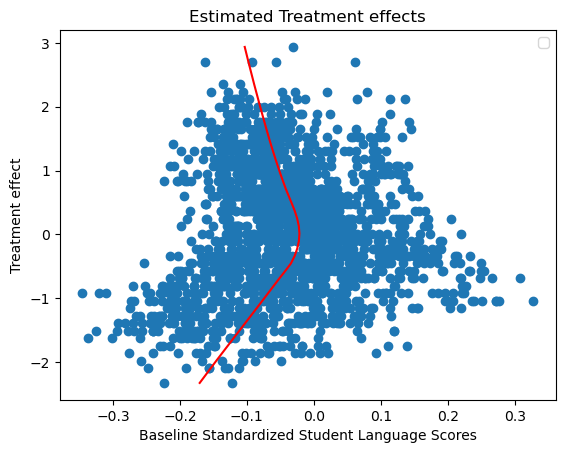

In [44]:
lowess = sm.nonparametric.lowess(df_chi['effects'], df_chi['std_chi2015'])

fig = plt.figure()
ax = plt.axes()

ax.scatter(df_chi['effects'], df_chi['std_chi2015'])
ax.plot(lowess[:, 1], lowess[:, 0], color='red')

ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("Baseline Standardized Student Language Scores")
plt.ylabel("Treatment effect")

In [45]:
df_chi['stu_highl'] = (df_chi['std_chi2015'] >= 0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
features_short = x[x.columns.drop(['std_chi2015'])]

In [47]:
int_formula = 'std_chi2017 ~ treat2015 + stu_highl + features_short + treat2015*stu_highl'
model = smf.ols(int_formula, data=df_chi)
results = model.fit(cov_type="HC3")

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            std_chi2017   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     42.92
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          5.32e-155
Time:                        15:54:15   Log-Likelihood:                -2242.6
No. Observations:                1988   AIC:                             4533.
Df Residuals:                    1964   BIC:                             4668.
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Part III - Discuss and Conclusion

The main goal of the project is to assess heterogeneity in a randomized control trial using advanced machine learning tools. In contrast to the conventional approach of using linear regression with interaction terms or conducting separate regression in each subgroups, the utilization of newly developed machine learning tools, such as the random causal forest employed in this study, offers several advantages. These tools provide increased flexibility and predictive power, allowing for a data-driven approach to identify important features and generate more accurate confidence intervals.

To achieve that, I first build up the random causal forest and use it to predict treatment effects for each indiviudal observation. I then plot the distribution of these effects predictions as a rough diagnose for heterogeneous treatment effects. I also examine the importance of different features and investigate whether the most important feature identified displays any interesting patterns of heterogeneity in relation to the estimated treatment effects. 

The findings suggest that the average treatment effects on endline reading test scores are close to zero. However, there is evidence of heterogeneity among students with different baseline reading test scores. Specifically, students with relatively higher baseline reading test scores tend to benefit from the treatment, while those with lower scores do not show significant improvements in reading.

On the other hand, for endline math and language test scores, the predicted treatment effects are mostly zero. Moreover, no notable patterns of heterogeneity were observed in these subjects. Nevertheless, the baseline subject test scores remain as the most important feature for predicting the treatment effects. 